<a href="https://colab.research.google.com/github/jbkalmbach/pzflow-paper-2021/blob/main/photo-z/pzflowRedshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pzflow
!pip install corner

     |████████████████████████████████| 7.9 MB 6.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pzflow: filename=pzflow-1.7.1-py3-none-any.whl size=7181862 sha256=321857b73fe47923e85b82e667387db5dac695eb5faca5cb6b09e5208ac3dfca
  Stored in directory: /root/.cache/pip/wheels/77/5a/38/f20c39240eeff5075e6b33a1afbfa46f065b345e625d10f979
Successfully built pzflow


## pzflow Photo-Z
This notebook shows how we built the normalizing flow with `pzflow` to learn the joint probability distribution of galaxy magnitudes and redshifts used for the plots in the paper.

In [2]:
import jax
print(f"jax version is {jax.__version__}")
import jax.numpy as np
import matplotlib.pyplot as plt
import corner

import pzflow
print(f"pzflow version is {pzflow.__version__}")
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data

jax version is 0.2.17
pzflow version is 1.7.1


## Load data

The photometric catalog we use in this section is the created using the accompanying notebook CMNN_cat_creation.ipynb in this folder. That notebook creates training and test catalogs using the same dataset used for experiments in the CMNN papers.

In [3]:
import os
import pandas as pd

In [35]:
!wget -O train.cat https://epyc.astro.washington.edu/~brycek/train.cat

--2021-08-12 23:53:32--  https://epyc.astro.washington.edu/~brycek/train.cat
Resolving epyc.astro.washington.edu (epyc.astro.washington.edu)... 140.142.4.22
Connecting to epyc.astro.washington.edu (epyc.astro.washington.edu)|140.142.4.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61000000 (58M)
Saving to: ‘train.cat’

train.cat           100%[===================>]  58.17M  58.3MB/s    in 1.0s    

2021-08-12 23:53:33 (58.3 MB/s) - ‘train.cat’ saved [61000000/61000000]



In [36]:
!wget -O test.cat https://epyc.astro.washington.edu/~brycek/test.cat

--2021-08-12 23:53:49--  https://epyc.astro.washington.edu/~brycek/test.cat
Resolving epyc.astro.washington.edu (epyc.astro.washington.edu)... 140.142.4.22
Connecting to epyc.astro.washington.edu (epyc.astro.washington.edu)|140.142.4.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12200000 (12M)
Saving to: ‘test.cat’

test.cat            100%[===================>]  11.63M  27.9MB/s    in 0.4s    

2021-08-12 23:53:49 (27.9 MB/s) - ‘test.cat’ saved [12200000/12200000]



In [37]:
trainingset = pd.read_csv('train.cat', delim_whitespace=2,
                          usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13),
                          names=['redshift', 'u', 'u_err', 
                                 'g', 'g_err', 'r', 'r_err', 'i', 'i_err', 
                                 'z', 'z_err', 'y', 'y_err'])

In [39]:
trainingset.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,1.681461,24.513591,0.050856,24.338341,0.015698,24.830337,0.018851,24.362460,0.023321,24.132958,0.033739,24.107587,0.092202
1,0.418160,25.103841,0.078745,24.739863,0.021387,23.851414,0.008973,23.719648,0.013819,23.606562,0.020873,23.596378,0.062148
2,1.523181,24.774840,0.065136,24.866467,0.023419,24.964820,0.021683,24.694521,0.029816,24.303987,0.037462,23.777432,0.081646
3,0.326217,25.525446,0.112280,24.891804,0.024220,24.165027,0.011245,23.995609,0.017522,23.992396,0.027481,23.869558,0.080475
4,1.977627,25.468525,0.109413,24.629200,0.019512,24.703632,0.017343,24.589501,0.028513,24.245597,0.037751,24.059314,0.100408


In [40]:
testset = pd.read_csv('test.cat', delim_whitespace=2,
                          usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13),
                          names=['redshift', 'u', 'u_err', 
                                 'g', 'g_err', 'r', 'r_err', 'i', 'i_err', 
                                 'z', 'z_err', 'y', 'y_err'])

In [41]:
testset.head()

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,1.144662,25.333989,0.096207,25.678332,0.044774,25.097415,0.023810,24.531963,0.028188,23.804846,0.023671,23.526051,0.058515
1,0.769482,25.494898,0.109606,24.843675,0.022815,23.642358,0.007824,22.585091,0.006094,21.991666,0.005000,21.785195,0.011419
2,0.725644,25.537796,0.146042,25.713801,0.046220,25.309939,0.029559,24.689278,0.030039,24.535282,0.048999,24.546267,0.143320
3,0.474720,24.632792,0.058014,24.288189,0.015522,23.292345,0.006206,23.000301,0.008129,22.848476,0.009890,22.797686,0.028531
4,0.691583,25.791469,0.160224,25.755306,0.048647,25.259562,0.027667,24.679736,0.028992,24.550292,0.045803,24.543009,0.132153


You can see the first column is redshift, and the subsequent columns are galaxy magnitudes in the 6 LSST bandpass filters. The data is in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

Now we will build a normalizing flow to model this data. We will construct a bijector made of two parts:

**1. Rolling Spline Coupling** --  
This is a bijector I created that alternates Neural Spline Couplings and "Rolling" layers.
This is the bijector I would recommend using "out of the box".
It has 5 parameters:
- `nlayers` - The number of (Neural Spline, Roll()) couplets in the chain
- `K` - The number of bins in the splines
- `B` - The range of the splines
- `hidden_layers` - the number of hidden layers in the neural network that calculates the spline bins and derivatives
- `hidden_dim` - the number of hidden dimensions in that same neural network

Only `nlayers` is required.
For this example, we will set `nlayers` = 7 to match the input dimension, and we will leave everything else to their default values.
Feel free to play around with changing the other parameters.


**2. Color Transform** --  
This is a bijector that performs the following transformation:  
$(\theta, \, R, \, u\!-\!g, \, g\!-\!r, \, r\!-\!i, \, i\!-\!z, \, z\!-\!y) \to  (\text{redshift}, \, u, \, g, \, r, \, i, \, z, \, y)$  
where
$\text{redshift} = \mathrm{softplus}(\theta)$
and
$r = R \cdot \sigma_r + \bar{r}$.  
Placing this Color Transform very last in our chain of bijectors means that the normalizing flow is optimizing the Neural Spline parameters to map the Gaussian samples onto the galaxy colors, rather than the galaxy magnitudes.
This is useful, as redshift correlates more directly with galaxy colors.
The value $R$ is just a normalized version of the $r$ band magnitude, which serves as a proxy for overall galaxy luminosity.
In addition, the transformation $\text{redshift} = \mathrm{softplus}(\theta)$ ensures that the sampled redshifts are always positive.

We construct the total bijector by chaining these two bijectors together.

After constructing the bijector, we create the flow by instantiating a `Flow` object.
We have to give it the bijector we just created, as well as the names of the columns in our data set.

In [42]:
# to use the r band as the reference magnitude
ref_idx = trainingset.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [trainingset.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([trainingset['redshift'], 
                      trainingset['r'], 
                      trainingset['u'] - trainingset['g'], 
                      trainingset['g'] - trainingset['r'], 
                      trainingset['r'] - trainingset['i'], 
                      trainingset['i'] - trainingset['z'], 
                      trainingset['z'] - trainingset['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = trainingset.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers),
)

# bijector = Chain(
#     RollingSplineCoupling(nlayers),
# )

In [43]:
# To create the normalizing flow, we have to provide
# 1. The names of the columns in our data set
# 2. The bijector
flow = Flow(['redshift', 'u', 'g', 'r', 'i', 'z', 'y'], bijector)

In [45]:
%%time
losses = flow.train(trainingset, epochs=10, batch_size=256, sample_errs=True, verbose=True)

Training 10 epochs 
Loss:


ValueError: ignored

In [47]:
trainingset = trainingset[['redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]

In [51]:
# to use the r band as the reference magnitude
ref_idx = trainingset.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [trainingset.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([trainingset['redshift'], 
                      trainingset['r'], 
                      trainingset['u'] - trainingset['g'], 
                      trainingset['g'] - trainingset['r'], 
                      trainingset['r'] - trainingset['i'], 
                      trainingset['i'] - trainingset['z'], 
                      trainingset['z'] - trainingset['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = trainingset.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers),
)

# bijector = Chain(
#     RollingSplineCoupling(nlayers),
# )

In [49]:
# To create the normalizing flow, we have to provide
# 1. The names of the columns in our data set
# 2. The bijector
flow = Flow(['redshift', 'u', 'g', 'r', 'i', 'z', 'y'], bijector)

In [50]:
%%time
losses = flow.train(trainingset, epochs=10, batch_size=256, sample_errs=True, verbose=True)

Training 10 epochs 
Loss:
(0) 5.9851
(1) -4.0175
(2) -4.2111
(3) -4.3719
(4) -4.4314
(5) -4.4314
(6) -4.4358
(7) -4.4861
(8) -4.5336
(9) -4.5999
(10) -4.5505
CPU times: user 3min 57s, sys: 17.1 s, total: 4min 15s
Wall time: 3min 44s


Now let's plot the training losses to make sure everything looks like we expect it to...

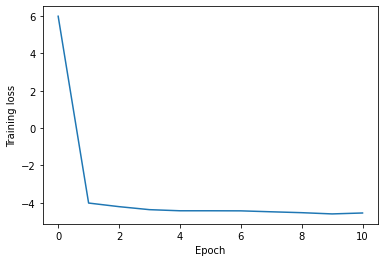

In [52]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make a corner plot, comparing these samples to the training set.

In [55]:
samples = flow.sample(10000, seed=0)

In [56]:
samples

,redshift,u,g,r,i,z,y
0,0.877408,24.197889,24.146675,23.887783,23.190401,22.849335,22.780933
1,1.098660,24.130112,24.162359,23.951622,23.609570,23.000483,22.993349
2,1.553035,24.687622,24.747726,24.818199,24.686438,24.505594,23.948320
3,1.126775,24.296795,24.807053,23.930769,23.350645,22.313292,22.096237
4,0.964961,25.163237,25.392673,25.174770,24.785858,24.193209,24.317799
...,...,...,...,...,...,...,...
9995,0.905955,24.081383,24.302040,24.276026,23.731670,23.500097,23.542709
9996,0.288743,24.297932,23.662704,22.965748,22.823822,22.768446,22.723036
9997,1.526733,24.304470,24.383989,24.464445,24.388577,24.103937,23.768114
9998,1.067384,24.170496,24.327816,24.100264,23.761370,23.074760,22.920900


<Figure size 864x864 with 0 Axes>

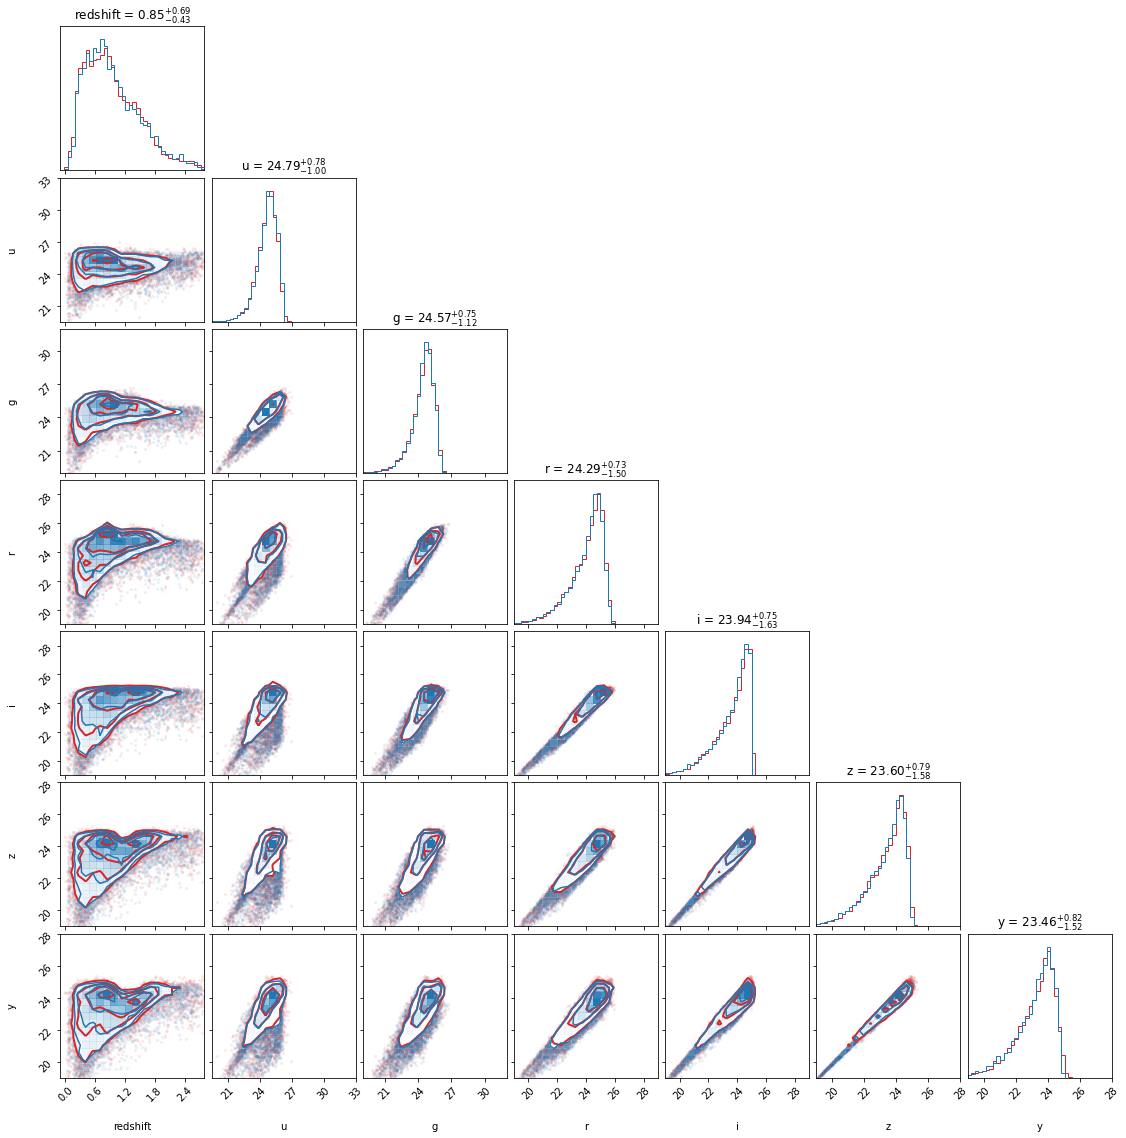

In [57]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.8), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

fig = corner.corner(samples, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(trainingset.iloc[:10000, :7], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);

In [58]:
np.min(trainingset['redshift'].values), np.max(trainingset['redshift'].values)

(DeviceArray(0.01423585, dtype=float32), DeviceArray(3.222168, dtype=float32))

We can also draw posteriors for magnitudes using the more general `posterior` method (in fact, `pz_estimate` is just a redshift wrapper of this method).

We can pass `column` and `grid` to calculate posteriors for different quanities.
For example, lets draw posteriors for the $u$ band:

In [59]:
u_grid = np.arange(21, 30, 0.1)
u_pdfs = dict()
for n_samples in (1, 5, 10):
    u_pdfs[n_samples] = flow.posterior(trainingset.iloc[:3], column='u', grid=u_grid, nsamples=n_samples)

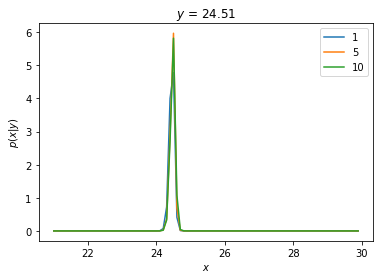

In [60]:
for i, pdf in u_pdfs.items():
    plt.plot(u_grid, pdf[0], label=i)
plt.legend()
plt.title(f"$y$ = {trainingset['u'].iloc[0]:.2f}")
plt.xlabel("$x$")
plt.ylabel("$p(x|y)$")
plt.show()

In [68]:
u_pdfs.keys()

dict_keys([1, 5, 10])

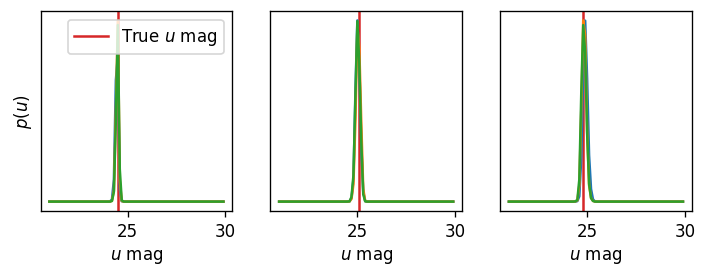

In [75]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

grid = np.arange(0, 2.02, 0.02)
for i,ax in enumerate(axes):
    true_u = trainingset['u'].iloc[i]
    ax.axvline(true_u, 0, 1, c="C3",
               label='True $u$ mag')
    for j in list(u_pdfs.keys()):
      ax.plot(u_grid, u_pdfs[j][i])
    ax.set(xlabel="$u$ mag", 
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(u)$')
plt.show()